In [49]:
#Importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
start_time=time.time()

In [50]:
#Plotting function
def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [51]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

trainset=datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader=DataLoader(trainset, batch_size=32, shuffle=True)

testset=datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader=DataLoader(testset, batch_size=32, shuffle=False)

In [52]:
dataiter=iter(trainloader)
images, labels=dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


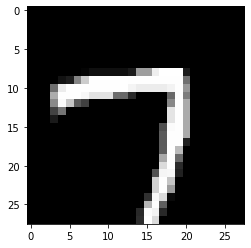

In [53]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [54]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1=nn.Conv2d(1, 32, 5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(32, 16, 5)
        self.fc1=nn.Linear(16*4*4, 128)
        self.fc2=nn.Linear(128, 64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        #print(x.shape)
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        x=F.softmax(x, dim=1)
        return x

model=Network()

In [55]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Epoch: 1/20
Mean epoch loss for train: 1.4819611245473225
Mean epoch loss for test: 2.1744984955833364
accuracy on epoch: 0.9804313099041534
Epoch: 2/20
Mean epoch loss for train: 1.4813487391789755
Mean epoch loss for test: 2.174442754385951
accuracy on epoch: 0.9807308306709265
Epoch: 3/20
Mean epoch loss for train: 1.480992239189148
Mean epoch loss for test: 2.174425176919078
accuracy on epoch: 0.9809305111821086
Epoch: 4/20
Mean epoch loss for train: 1.480829718208313
Mean epoch loss for test: 2.1743645759436268
accuracy on epoch: 0.9813298722044729
Epoch: 5/20
Mean epoch loss for train: 1.4804029920578003
Mean epoch loss for test: 2.17434606993922
accuracy on epoch: 0.9814297124600639
Epoch: 6/20
Mean epoch loss for train: 1.48022952931722
Mean epoch loss for test: 2.1743164908009978
accuracy on epoch: 0.981629392971246
Epoch: 7/20
Mean epoch loss for train: 1.4796148387273154
Mean epoch loss for test: 2.174281376238448
accuracy on epoch: 0.9818290734824281
Epoch: 8/20
Mean epoch 

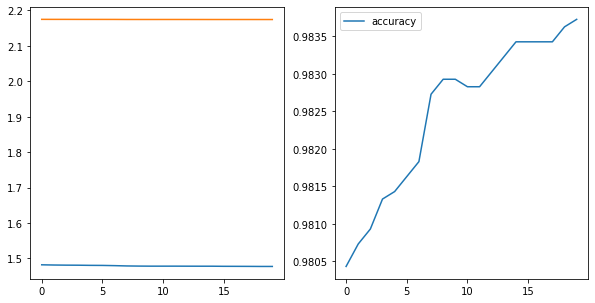

In [57]:
criterion=nn.CrossEntropyLoss()
def torch_fit(trainloader, testloader, criterion, lr, num_epochs, model, device):
    optimizer=optim.SGD(model.parameters(), lr)

    train_losses=[]
    test_losses=[]
    accuracy=[]
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')

        train_epoch_loss=[]
        for i, (images, labels) in enumerate(iter(trainloader)):
            images=images.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            pred=model.forward(images)
            loss=criterion(pred, labels)
            train_epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            
            test_epoch_list=[]
            acc_on_epoch=[]
            for j, (imagest, labelst) in enumerate(iter(testloader)):
                imagest=imagest.to(device)
                labelst=labelst.to(device)
                preds=F.softmax(model(imagest), dim=1)
                losst=criterion(preds, labelst)
                test_epoch_list.append(losst.item())

                acc_pred=preds.argmax(dim=1)
                acc=(acc_pred == labelst).sum()/ len(labelst)
                acc_on_epoch.append(acc.item())
    
        mean_acc=sum(acc_on_epoch)/len(acc_on_epoch)
        accuracy.append(mean_acc)

        test_loss_mean=sum(test_epoch_list)/len(test_epoch_list)
        test_losses.append(test_loss_mean)

        train_loss_mean=sum(train_epoch_loss)/len(train_epoch_loss)
        train_losses.append(train_loss_mean)

        print(f'Mean epoch loss for train: {train_loss_mean}')
        print(f'Mean epoch loss for test: {test_loss_mean}')
        print(f'accuracy on epoch: {mean_acc}')


    x_axis_acc=list(range(num_epochs))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    
    plt.subplot(1,2,2)
    plt.plot(x_axis_acc,accuracy, label='accuracy')
    plt.legend()
    plt.show()

ans=torch_fit(trainloader=trainloader, testloader=testloader,criterion=criterion, lr=0.001, num_epochs=20, model=model, device=device)
    



In [61]:
images, labels = next(iter(testloader))
images=images.to(device)
labels=labels.to(device)
#images.resize_(images.shape[0], 1, 784) 
logits = model.forward(images[0,:])
ps = F.softmax(logits, dim=1)
view_classify(images[0].view(1, 28, 28), ps)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 784]